In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import numpy
import pickle
import os, sys
import scipy
import h5py
from scipy.signal import periodogram,get_window,coherence
#from scdmsPyTools.Cuts.General import removeOutliers
#from scdmsPyTools.Traces.Stats import slope
#from scdmsPyTools.General.Complex import stdComplex
#from scdmsPyTools.Traces.Filtering import *
from scipy.stats import skew


#datapath = '/gpfs/slac/staas/fs1/g/supercdms/tf/northwestern/AnimalData/AR68dm/*/'
#pulsefiles=glob(datapath + series + '/*' + series + '*.hdf5')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf

In [2]:
series    = '20220621_102222'
data_path = os.path.join('/data/USRP_Noise_Scans',series.split('_')[0],series)

In [3]:
sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)

Line Delay file:  /data/USRP_Noise_Scans/20220621/20220621_102222/USRP_Delay_20220621_102222.h5
VNA scan file:    /data/USRP_Noise_Scans/20220621/20220621_102222/USRP_VNA_20220621_102222.h5
Timestream files: ['/data/USRP_Noise_Scans/20220621/20220621_102222/USRP_Noise_20220621_102222_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220621/20220621_102222/noise_averages_20220621_102222.h5


In [4]:
def readDataFile(data_path):
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
    metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)
    
    f_tone = h5py.File(tone_files[0], 'r')
    
    res_ts = np.array(f_tone['raw_data0']['A_RX2']['data'])[0,:]
    n_pts  = len(res_ts)
    
    times  = np.arange(n_pts)/metadata['rate'] *100
    mags   = abs(res_ts)
    phases = np.angle(res_ts)
    
    res = dict()
    res['Phase']=phases-np.angle(avg_S21s[0])
    res['Magnitude']=mags-abs(avg_S21s[0])
    res['Time']=times
    res['Fs']=1e6
    res['number_samples']=n_pts
    res['chan_names']=['Phase','Magnitude']
    res['cut_idx'] = np.argmin(np.abs(times-0.001))
    return res

Line Delay file:  /data/USRP_Noise_Scans/20220621/20220621_102222/USRP_Delay_20220621_102222.h5
VNA scan file:    /data/USRP_Noise_Scans/20220621/20220621_102222/USRP_VNA_20220621_102222.h5
Timestream files: ['/data/USRP_Noise_Scans/20220621/20220621_102222/USRP_Noise_20220621_102222_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220621/20220621_102222/noise_averages_20220621_102222.h5


<IPython.core.display.Javascript object>


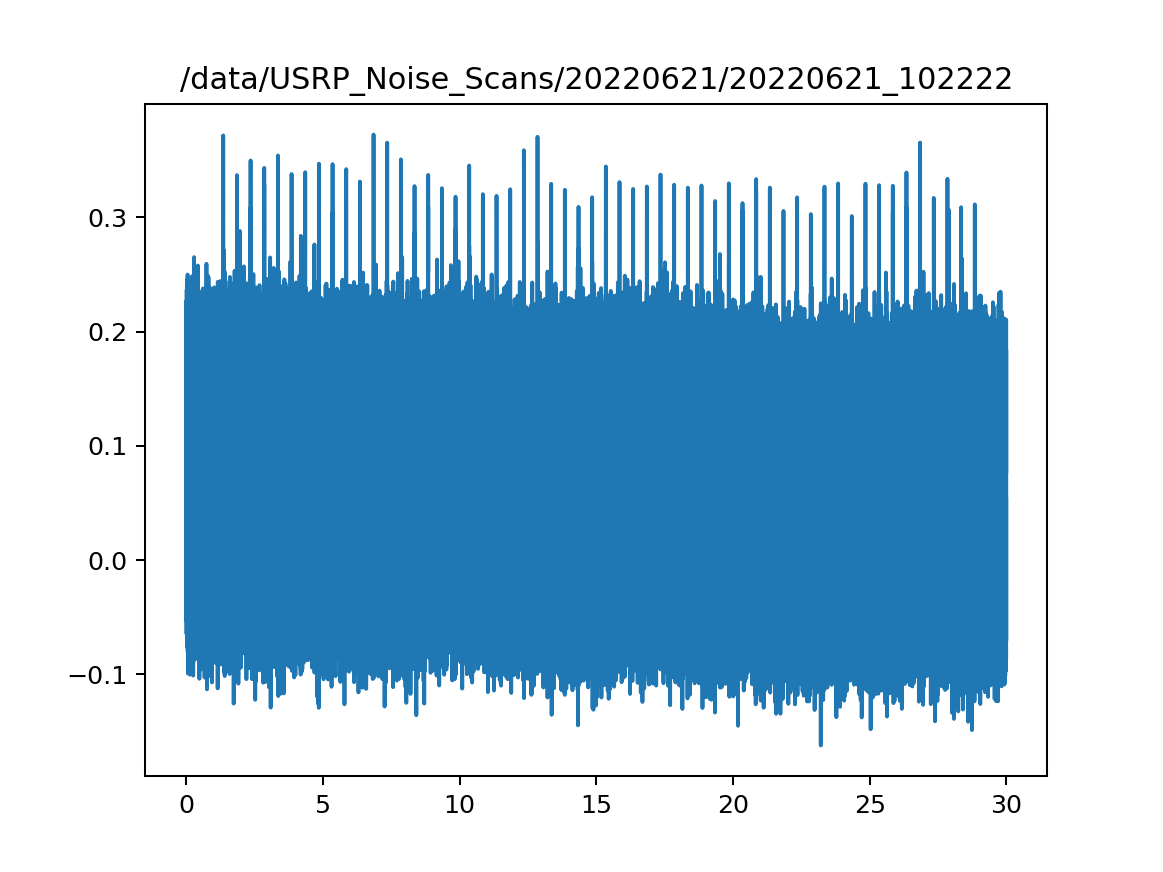

In [5]:
%matplotlib notebook

# for i in range(10,20):
#     if(i < 10):
#         idStr='000'+str(i)
#     elif (i < 100):
#         idStr='00'+str(i)
#     else:
#         idStr = '0'+str(i)
#     fileStr = tone_files[1]
# #     fileStr='/data/USRP_Noise_scans/long_timestream/mkid11-b-'+idStr+'.np'
#     res = readDataFile(fileStr)
    
#     plt.figure(fileStr)
#     plt.plot(res['Time'],res['Phase'])
#     plt.title(fileStr)
# #     print(len(res['Phase']))
#     del res
#     plt.show()
    
res = readDataFile(data_path)
    
plt.figure()
plt.plot(res['Time'][res['cut_idx']:],res['Phase'][res['cut_idx']:])
plt.title(data_path)
#     print(len(res['Phase']))
del res
plt.show()

Line Delay file:  /data/USRP_Noise_Scans/20220621/20220621_102222/USRP_Delay_20220621_102222.h5
VNA scan file:    /data/USRP_Noise_Scans/20220621/20220621_102222/USRP_VNA_20220621_102222.h5
Timestream files: ['/data/USRP_Noise_Scans/20220621/20220621_102222/USRP_Noise_20220621_102222_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220621/20220621_102222/noise_averages_20220621_102222.h5


<IPython.core.display.Javascript object>


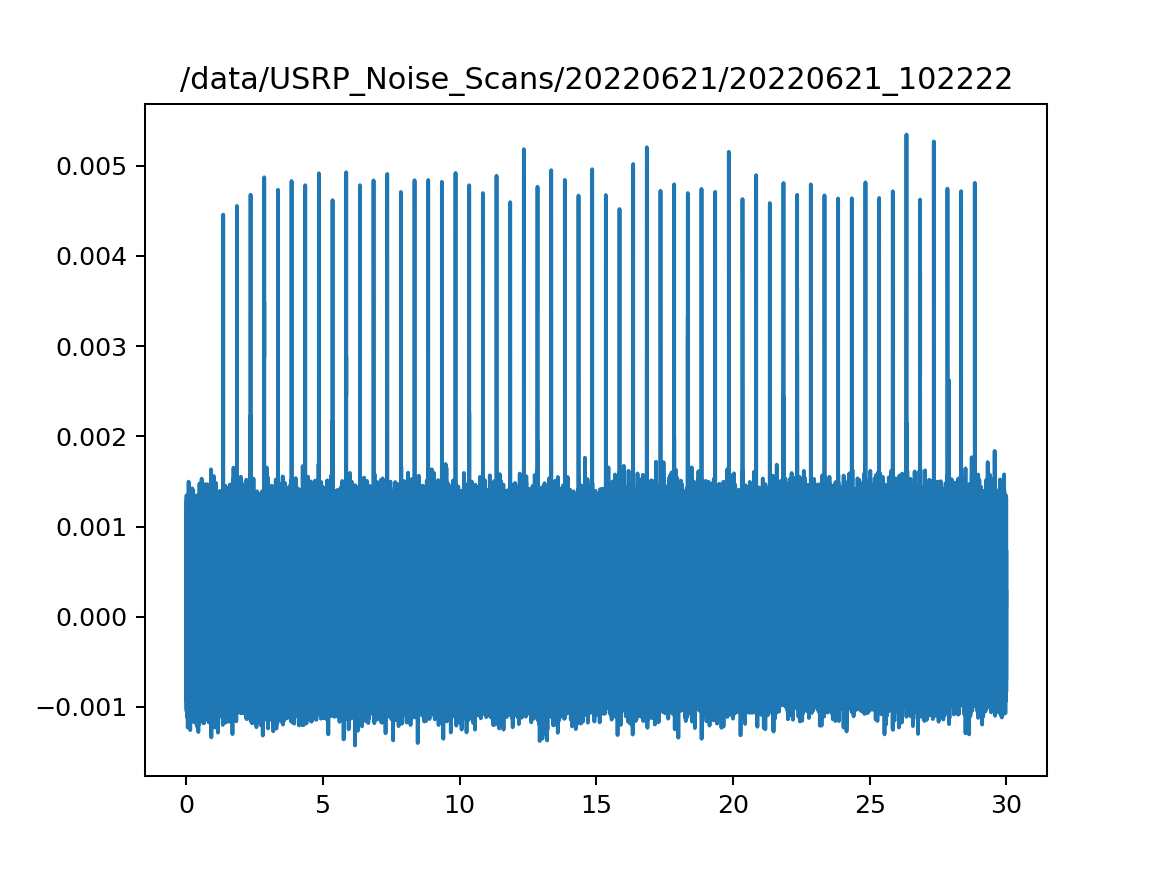

In [7]:
res = readDataFile(data_path)
    
plt.figure()
plt.plot(res['Time'][res['cut_idx']:],res['Magnitude'][res['cut_idx']:])
plt.title(data_path)
#     print(len(res['Phase']))
del res
plt.show()

In [8]:
def pulse(x,x0,tau1=20e-6,tau2=200e-6):
    dx=(x-x0)
    dx*=np.heaviside(dx,1)
    return (np.exp(-dx/tau1)-np.exp(-dx/tau2))/(tau1-tau2)*np.heaviside(dx,1)

def pulseFromTemplate(template,noisepsd,fs):
    
    # calculate the time-domain optimum filter
    phi = irfft(rfft(template)/noisepsd).real
    # calculate the normalization of the optimum filter
    norm = np.dot(phi, template)
        
    # calculate the expected energy resolution
    resolution = 1.0/(np.dot(phi, template)/fs)**0.5
    
    template = phi/norm*fs
    
    return template,[phi,norm,resolution]

def getEvents(filename, trig_channel='Phase', trig_th = 2.0, rising_edge = True, maxAlign=True,
       pretrig = 1024, trace_len = 4096, trig_sep = 4096, ds=4, pretrig_template = 1024, tauRise=20e-6, tauFall=300e-6,  
                                     ACcoupled=True, verbose=False, template=None):
    '''
    This function takes data from continuous DAQ, where each file contains 1 sec of data
    It slices the 1sec of data into events with a level trigger
    
    Double exponential template is generated if no template is given. For OF template, run 'pulseFromTemplate' to generate
    apropriate template for use with trigger function
    
    '''
    res=readDataFile(filename)
    chan_names=res['chan_names']
    number_samples=res['number_samples']
 
    #make sure trigger channel is valid
    chan_names = res['chan_names']
    if(trig_channel not in chan_names):
        trig_channel='Phase'
        if(verbose):
            print('Trigger Channel Defaulting to Phase')
 
    #setup trigger template
    fs=res['Fs']
    dt=1.0/fs
    if(template is None):
        #produce shaping template
        pretrigger=pretrig_template*dt
        xtemplate=np.arange(0,trace_len)*dt
        template=pulse(xtemplate,pretrigger,tau1=tauRise,tau2=tauFall)
    else:
        oldtl = trace_len
        trace_len = len(template)
        if(oldtl == trig_sep):
            trig_sep = trace_len
        pretrig_template = np.argmax(template)
        xtemplate=np.arange(0,trace_len)*dt    
    
    if(ACcoupled): #removes DC component; flat trace gives 0
        template-=np.mean(template)
 
    trace=res[trig_channel]
    #downsample and average template and trace
    meandt=dt*ds
    trig_sep_ds = int(trig_sep/ds)
    meanTemplate=np.mean(template.reshape(int(len(template)/ds),ds),axis=1)
    meanTrace=np.mean(trace.reshape(int(len(trace)/ds),ds),axis=1)
 
    #pulse shaping maintainin correct amplitude
    filtered_data = scipy.signal.fftconvolve(meanTrace, meanTemplate[::-1], mode="valid")
    #filtered_data = np.correlate(meanTrace,meanTemplate)*meandt
#     plt.plot(filtered_data)
#     plt.show()
 
    if (rising_edge): #rising edge
        if(verbose):
            print('Triggering on rising edge')
        trigA = (filtered_data[0:-1] < trig_th)
        trigB = (filtered_data[1:] > trig_th)
    else: #falling edge
        if(verbose):
            print('Triggering on falling edge')
        trigA = (filtered_data[0:1] > trig_th)
        trigB = (filtered_data[1:] < trig_th)
    trigger_condition = trigA & trigB
    trigger_points=np.flatnonzero(trigger_condition)+1
 
    rm_index = []
    n_trig = len(trigger_points)
    n_trig_pts = n_trig
    idx = 0
    alignPreTrig = 200
    alignPostTrig =500
    while (idx < n_trig-2):
 
        #remove redundant triggers
        nidx = idx + 1
        while ( (nidx< n_trig) and ((trigger_points[nidx] - trigger_points[idx])< trig_sep_ds) ):
            rm_index.append(nidx)
            nidx += 1
 
        #update loop
        idx = nidx
 
    if(len(rm_index) > 0):
        rm_index = np.array(rm_index)
        trigger_points = np.delete(trigger_points, rm_index)
 
    #align trigger with pulse maximum                                                                                                                                         
    if(maxAlign):
        for idx in range(0,len(trigger_points)):
            trigWindowStart=trigger_points[idx] - int(alignPreTrig/ds)
            trigWindowEnd=trigger_points[idx] + int(alignPostTrig/ds)
            if(trigWindowStart > 0 and trigWindowEnd < len(filtered_data)):
                trigger_points[idx] = np.argmax(filtered_data[trigWindowStart:trigWindowEnd])+trigWindowStart
 
    if(ds > 1):
        trigger_points*=ds
    trigger_points += pretrig_template
    n_trig = len(trigger_points)
 
    for ch_str in chan_names:
        rm_index = []
        singleTrace=res[ch_str]
        res[ch_str] = []
        for i in range(0,len(trigger_points)):            
            trigpt = trigger_points[i]
 
            #avoid traces too close to the edge of the trace
            trigAreaStart=trigpt - pretrig
            trigAreaEnd=trigpt + trace_len - pretrig
            if(trigAreaStart < 0 or trigAreaEnd > len(singleTrace)):
                rm_index.append(i)
                continue
            res[ch_str].append(singleTrace[trigAreaStart:trigAreaEnd])
        if(len(rm_index) > 0):
            rm_index = np.array(rm_index)
            trigger_points = np.delete(trigger_points, rm_index)
        res[ch_str] = np.array(res[ch_str])
 
    res['trigpt'] = trigger_points
    res['filename'] = np.full(n_trig,filename)
    res['trigRate'] = np.full(n_trig,n_trig)
    res['trigPts'] = np.full(n_trig,n_trig_pts)
 
    del singleTrace
    del filtered_data
    del trigger_condition
    del trigA,trigB
 
    return res

In [ ]:
# traceLength=8096
# pulseCount=0
# traces = {}
# for i in range(0,900):
#     if(i < 10):
#         idStr='000'+str(i)
#     elif (i < 100):
#         idStr='00'+str(i)
#     else:
#         idStr = '0'+str(i)
#     fileStr='long_timestream/mkid11-b-'+idStr+'.np'
    
#     try:
#         events=getEvents(fileStr,ds=1,trig_th=200000.0, trace_len = traceLength, trig_sep = traceLength, tauFall=500e-6)
#         nEvents=len(events['Phase'])
#         for i in range(0,nEvents):
#             pulseCount+=1
#             trace=events['Phase'][i]
#             trace -= numpy.mean(trace[0:800])
#             traces[pulseCount] = trace
            
#     except:
#         print('Skipping '+fileStr)
#         print('there was an error and you should probably do some digging')
#     #xlim(0.5,3)
#     #ylim(-0.25,0.5)
# print(pulseCount)

In [17]:
traceLength=8096
pulseCount=0
traces = {}

events=getEvents(data_path,ds=1,trig_th=2.0e4, trace_len = traceLength, trig_sep = traceLength, tauFall=500e-6)
nEvents=len(events['Phase'])
for i in range(0,nEvents):
    pulseCount+=1
    trace=events['Phase'][i]
    trace -= numpy.mean(trace[0:800])
    traces[pulseCount] = trace

print(pulseCount)

Line Delay file:  /data/USRP_Noise_Scans/20220621/20220621_102222/USRP_Delay_20220621_102222.h5
VNA scan file:    /data/USRP_Noise_Scans/20220621/20220621_102222/USRP_VNA_20220621_102222.h5
Timestream files: ['/data/USRP_Noise_Scans/20220621/20220621_102222/USRP_Noise_20220621_102222_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220621/20220621_102222/noise_averages_20220621_102222.h5
58


<IPython.core.display.Javascript object>


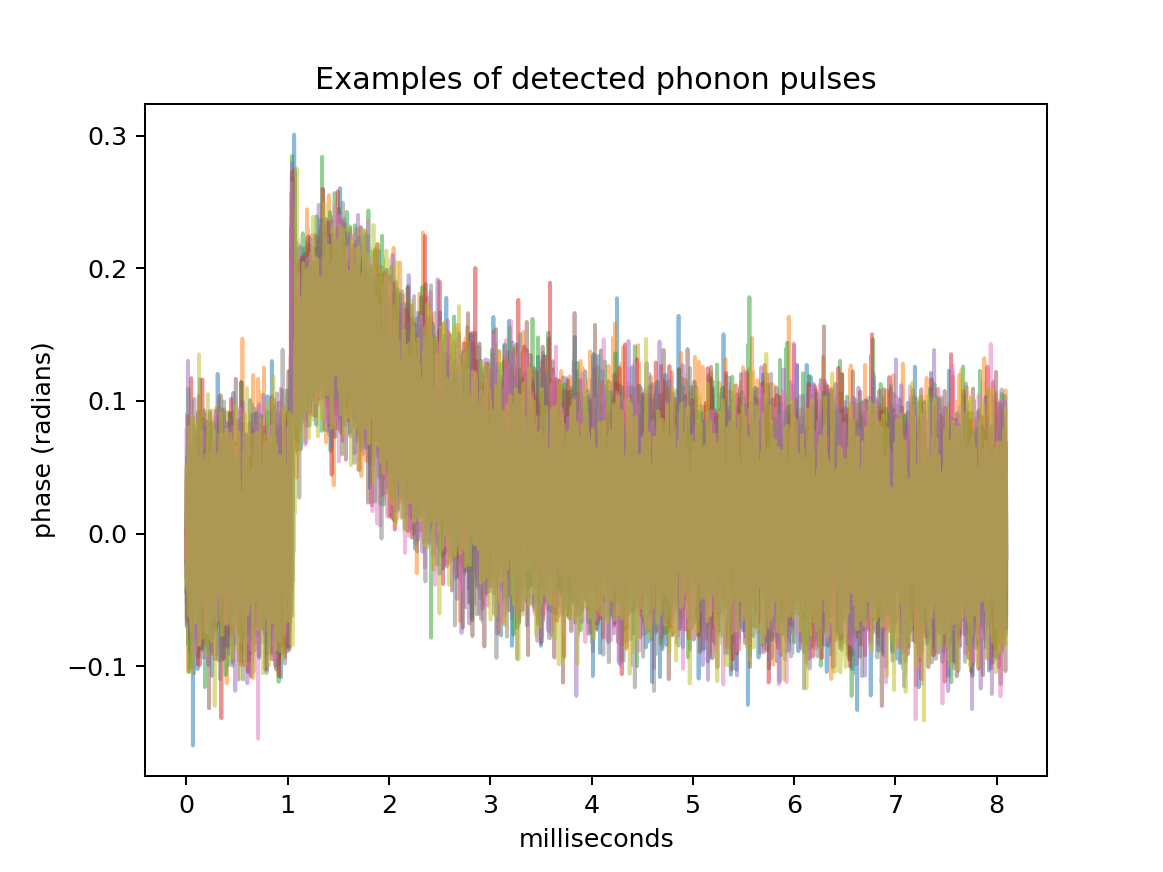

Text(0.5, 1.0, 'Examples of detected phonon pulses')

In [18]:
# %matplotlib widget

plt.figure(102)
for pulseNum in traces:
    if pulseNum < 10:
        trace = traces[pulseNum]        
        plt.plot(numpy.arange(0,traceLength)/1e3,trace,alpha=0.5)
        
plt.ylabel('phase (radians)')
plt.xlabel('milliseconds')
plt.title('Examples of detected phonon pulses')

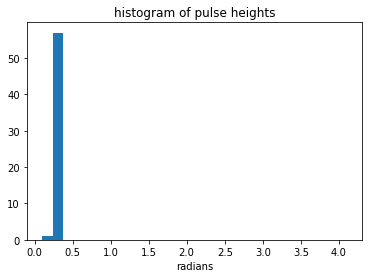

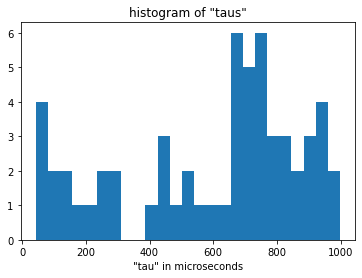

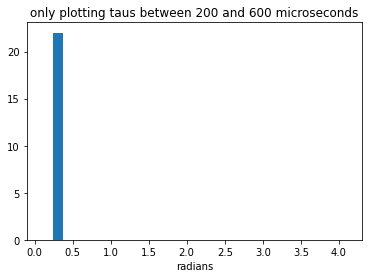

In [20]:
%matplotlib inline
pulse_heights = []
taus = []
interestingPulses = []
interestingPulseHeights = []
for pulseNum in traces:
    trace = traces[pulseNum]
    pulse_max = np.amax(trace[1000:2000])
    pulse_heights.append(pulse_max)
    pulse_max_idxs = np.argwhere(trace == pulse_max)
    pulse_max_idx = pulse_max_idxs[0][0]
    trace_after_pulse = trace[pulse_max_idx:pulse_max_idx+1000]
    tau = np.argmin(np.abs(trace_after_pulse - pulse_max/np.e))
    taus.append(tau)
    
    if tau > 600 and tau < 800:
        interestingPulses.append(pulseNum)
        interestingPulseHeights.append(pulse_max)

        
height_bins = np.linspace(0.1,4.1,30)
plt.figure('pulse heights')
plt.hist(pulse_heights,bins=height_bins)
plt.xlabel('radians')
plt.title('histogram of pulse heights')
plt.savefig('pulse_heights.png')

plt.figure('taus')
plt.xlabel('"tau" in microseconds')
plt.title('histogram of "taus"')
plt.hist(taus,bins=25)
plt.savefig('pulse_lifetimes.png')

plt.figure('interesting pulse heights')
plt.hist(interestingPulseHeights,bins = height_bins)
plt.xlabel('radians')
plt.title('only plotting taus between 200 and 600 microseconds')
plt.savefig('pulse_heights_lifetime_cut.png')
plt.show()

In [ ]:
plt.close('all')